## 神经网络用于计算机视觉

本章包括以下内容：

- 理解卷积神经网络（ConvNet）
- 使用数据增强（data argument）来降低过拟合
- 使用预训练的CNN进行特征提取
- 微调预训练的CNN
- 将CNN学到的内容及其如何做出分类决策可视化

In [4]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from IPython.display import Image

In [1]:
from keras import models, layers, optimizers, losses, metrics
from keras.utils import plot_model

/home/pzhang/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
model = models.Sequential()
model.add(
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [3]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                36928     
__________

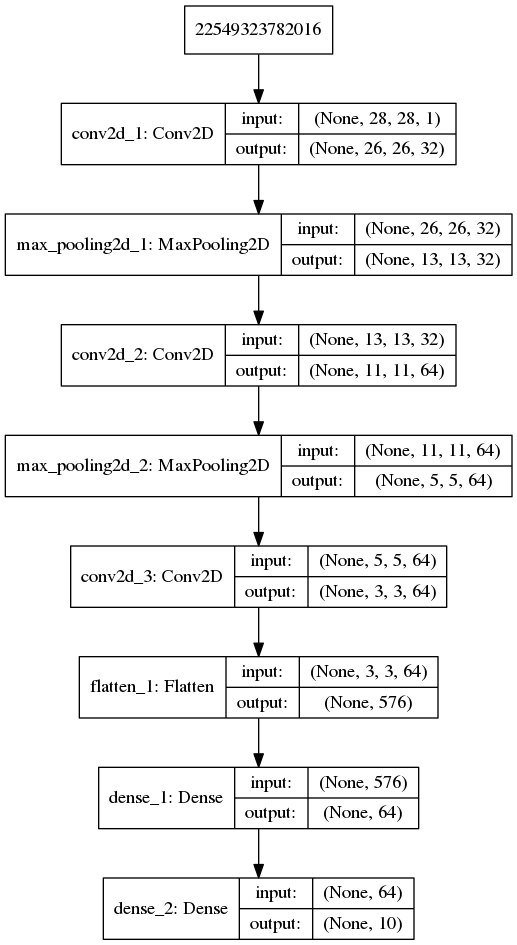

In [5]:
# plot model
# need pyplot, pyplot-ng and graphviz
plot_model(model, show_shapes=True, to_file='model.png')

Image(filename='model.png')

In [11]:
# 在MNIST上训练CNN
from keras.datasets import mnist
from keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

11493376/11490434 [==============================] - 256s 22us/step


In [12]:
model.compile(
    optimizer=optimizers.RMSprop(),
    loss=losses.categorical_crossentropy,
    metrics=[metrics.categorical_accuracy])

In [13]:
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
60000/60000 [==============================] - 9s 144us/step - loss: 0.1622 - categorical_accuracy: 0.9494
Epoch 2/5
60000/60000 [==============================] - 6s 92us/step - loss: 0.0453 - categorical_accuracy: 0.9857
Epoch 3/5
60000/60000 [==============================] - 6s 93us/step - loss: 0.0305 - categorical_accuracy: 0.9906
Epoch 4/5
60000/60000 [==============================] - 5s 86us/step - loss: 0.0241 - categorical_accuracy: 0.9926
Epoch 5/5
60000/60000 [==============================] - 5s 88us/step - loss: 0.0186 - categorical_accuracy: 0.9945


In [14]:
model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 1s 60us/step


[0.026701377056132333, 0.9925]

In [15]:
model.save('mnist_cnn1.h5')

In [16]:
results = model.predict(test_images[:6], batch_size=1, verbose=1)
np.argmax(results, axis=1)

6/6 [==============================] - 0s 6ms/step


array([7, 2, 1, 0, 4, 1])

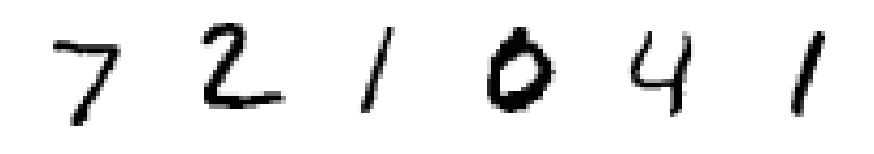

In [17]:
f, ax = plt.subplots(1, 6, figsize=(15,3))
for i, img in enumerate(test_images[:6]):
    ax[i].imshow(img.reshape(28, 28), cmap=plt.cm.binary)
    ax[i].axis('off')
plt.show()    

## 基于小数据集的CNN

Kaggle对猫和狗分类的数据集中包含4000张猫和够的图片。这里将其中2000张图片用于训练，1000张用于验证，1000张用于测试。

首先从该小数据集训练一个CNN

然后利用数据增强来降低过拟合

接着预训练的网络做特征提取以及对预训练的网络进行微调

In [6]:
!ls

cat_and_dog_1.h5   ch02.ipynb  create_small_cats_and_dogs_datasets.py
cat_and_dog_2.h5   ch03.ipynb  mnist_cnn1.h5
cat_and_dog.ipynb  ch05.ipynb  model.png


In [14]:
# split train, validation and test dataset
import os
import shutil

original_train_dir = '/home/pzhang/Downloads/ml_datasets/cat-and-dog/training_set'

base_dir = '/home/pzhang/Downloads/ml_datasets/cats_and_dogs_small'
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

dir_list = ['train', 'validation', 'test']
ctag = ['cats', 'dogs']

for dir_name in dir_list:
    path = os.path.join(base_dir, dir_name)
    if not os.path.exists(path):
        os.mkdir(path)
    for n in ctag:
        temp_path = os.path.join(path, n)
        if not os.path.exists(temp_path):
            os.mkdir(temp_path)

# 将前1000张猫的图像复制到 cats_and_dogs_small/train/cats 目录
fnames = ['cat.{}.jpg'.format(i + 1) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_train_dir, 'cats', fname)
    dst = os.path.join(base_dir, 'train', 'cats', fname)
    shutil.copyfile(src, dst)
train_cats_dir, _ = os.path.split(dst)

# 接下来的500张猫的图像复制到 cats_and_dogs_small/vadiation/cats 目录
fnames = ['cat.{}.jpg'.format(i + 1) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_train_dir, 'cats', fname)
    dst = os.path.join(base_dir, 'validation', 'cats', fname)
    shutil.copyfile(src, dst)
validation_cats_dir, _ = os.path.split(dst)

# 接下来的500张猫的图像复制到 cats_and_dogs_small/test/cats 目录
fnames = ['cat.{}.jpg'.format(i + 1) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_train_dir, 'cats', fname)
    dst = os.path.join(base_dir, 'test', 'cats', fname)
    shutil.copyfile(src, dst)
test_cats_dir, _ = os.path.split(dst)

# 将前1000张狗的图像复制到 cats_and_dogs_small/train/dogs 目录
fnames = ['dog.{}.jpg'.format(i + 1) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_train_dir, 'dogs', fname)
    dst = os.path.join(base_dir, 'train', 'dogs', fname)
    shutil.copyfile(src, dst)
train_dogs_dir, _ = os.path.split(dst)

# 接下来的500张狗的图像复制到 cats_and_dogs_small/vadiation/dogs 目录
fnames = ['dog.{}.jpg'.format(i + 1) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_train_dir, 'dogs', fname)
    dst = os.path.join(base_dir, 'validation', 'dogs', fname)
    shutil.copyfile(src, dst)
validation_dogs_dir, _ = os.path.split(dst)

# 接下来的500张狗的图像复制到 cats_and_dogs_small/test/dogs 目录
fnames = ['dog.{}.jpg'.format(i + 1) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_train_dir, 'dogs', fname)
    dst = os.path.join(base_dir, 'test', 'dogs', fname)
    shutil.copyfile(src, dst)
    test_dogs_dir, _ = os.path.split(dst)

print('total training cat images: ', len(os.listdir(train_cats_dir)))
print('total training dog images: ', len(os.listdir(train_dogs_dir)))
print('total validation cat images: ', len(os.listdir(validation_cats_dir)))
print('total validation dog images: ', len(os.listdir(validation_dogs_dir)))
print('total test cat images: ', len(os.listdir(test_cats_dir)))
print('total test dog images: ', len(os.listdir(test_dogs_dir)))

total training cat images:  1000
total training dog images:  1000
total validation cat images:  500
total validation dog images:  500
total test cat images:  500
total test dog images:  500


### 构建网络

`Conv`和`MaxPooling`层交替堆叠

In [ ]:
input